Pre-processing data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

In [2]:
# Features and Labels
X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

GridSearchCV

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(5,)))  # Explicit input layer with shape matching the number of features
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
optimizers = ['rmsprop', 'adam']
param_grid = dict(model__optimizer=optimizers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.494000 using {'model__optimizer': 'rmsprop'}


RandomizedSearchCV

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

# Selecting the features and labels
X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

def create_model(dropout_rate=0.0, activation='relu'):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation=activation),
        Dropout(dropout_rate),
        Dense(64, activation=activation),
        Dropout(dropout_rate),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, verbose=0)

# Define the parameter grid to search
param_dist = {
    'model__dropout_rate': [0.0, 0.25, 0.5],  # Dropout rates to try
    'model__activation': ['relu', 'tanh'],   # Activation functions to try
    'batch_size': [10, 20, 50],
    'epochs': [10, 50, 100]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled, increase for better results
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_results = random_search.fit(X_train, y_train)

# Print best score and parameters
print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best: 0.980999 using {'model__dropout_rate': 0.25, 'model__activation': 'relu', 'epochs': 100, 'batch_size': 50}


Bayesian Optimization with Hyperopt

In [8]:
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

# Selecting the features and labels
X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the function to create and compile the model
def create_model(params):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(int(params['units_1']), activation=params['activation']),
        Dropout(params['dropout']),
        Dense(int(params['units_2']), activation=params['activation']),
        Dropout(params['dropout']),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the objective function for hyperparameter optimization
def objective(params):
    model = create_model(params)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=int(params['epochs']),
        batch_size=int(params['batch_size']),
        verbose=0
    )
    val_accuracy = max(history.history['val_accuracy'])  # Use validation accuracy as the objective
    return {'loss': -val_accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'units_1': hp.quniform('units_1', 64, 256, 32),
    'units_2': hp.quniform('units_2', 32, 128, 16),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -4, -2),
    'batch_size': hp.quniform('batch_size', 16, 64, 16),
    'epochs': hp.quniform('epochs', 10, 50, 10),
    'activation': hp.choice('activation', ['relu', 'tanh'])
}

# Run the Bayesian Optimization
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,  # Adjust this to try more parameter combinations
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Print the best parameters
print("Best Parameters:", best_params)

# Map the indices back to their values for categorical parameters
best_params['activation'] = ['relu', 'tanh'][best_params['activation']]

# Re-train the model with the best parameters
final_model = create_model(best_params)
final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=int(best_params['epochs']),
    batch_size=int(best_params['batch_size']),
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


100%|██████████| 20/20 [02:12<00:00,  6.64s/trial, best loss: -0.9750000238418579]
Best Parameters: {'activation': 0, 'batch_size': 32.0, 'dropout': 0.05512156611263713, 'epochs': 50.0, 'learning_rate': 0.018952742781740143, 'units_1': 224.0, 'units_2': 48.0}
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6700 - loss: 0.6978 - val_accuracy: 0.8719 - val_loss: 0.2779
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.8641 - loss: 0.3165 - val_accuracy: 0.8756 - val_loss: 0.3389
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.8771 - loss: 0.2946 - val_accuracy: 0.9025 - val_loss: 0.2257
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.9002 - loss: 0.2355 - val_accuracy: 0.9137 - val_loss: 0.1977
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.9079 - loss: 0.2149 - val_accuracy: 0.9325 - val_loss: 0.1434
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.9077 - loss: 0.2304 - va

Sequential Model-Based Optimization (SMBO) with Scikit-Optimize

d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Pyth

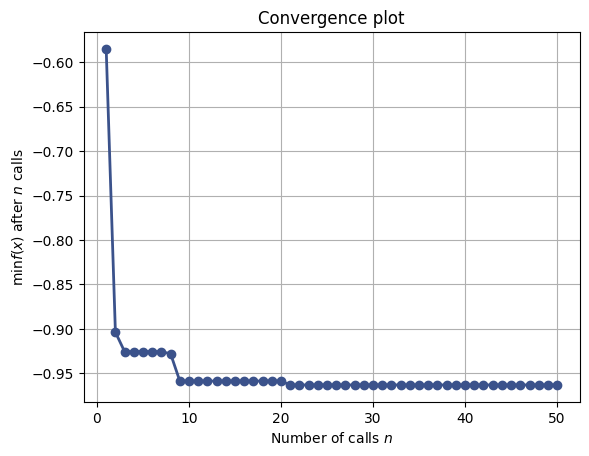

Best parameters are: [0.018343865759785787, 2, 58, 0.1573040099710361]
Best validation accuracy achieved: 0.963


In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the space of hyperparameters to optimize
space = [
    Real(0.0001, 0.1, name='learning_rate'),
    Integer(1, 3, name='n_layers'),
    Integer(10, 100, name='n_neurons'),
    Real(0.1, 0.5, name='dropout_rate')
]

# Define the structure of the model using the sampled hyperparameters
@use_named_args(space)
def objective(learning_rate, n_layers, n_neurons, dropout_rate):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    val_accuracy = np.max(history.history['val_accuracy'])
    return -val_accuracy

# Run the optimization
result = gp_minimize(objective, space, n_calls=50, random_state=0)

# Plotting convergence
plot_convergence(result)
plt.show()

print("Best parameters are: {}".format(result.x))
print("Best validation accuracy achieved: {:.3f}".format(-result.fun))



Optuna

d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Software\Pyth

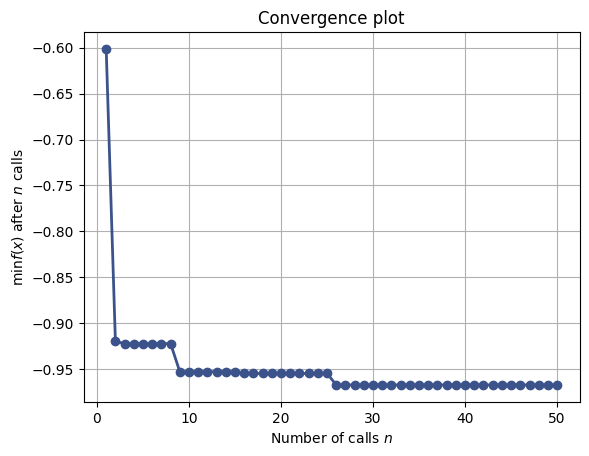

Best parameters are: [0.0410277969982411, 1, 42, 0.1]
Best validation accuracy achieved: 0.967


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the space of hyperparameters to optimize
space = [
    Real(0.0001, 0.1, name='learning_rate'),
    Integer(1, 3, name='n_layers'),
    Integer(10, 100, name='n_neurons'),
    Real(0.1, 0.5, name='dropout_rate')
]

# Define the structure of the model using the sampled hyperparameters
@use_named_args(space)
def objective(learning_rate, n_layers, n_neurons, dropout_rate):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    val_accuracy = np.max(history.history['val_accuracy'])
    return -val_accuracy

# Run the optimization
result = gp_minimize(objective, space, n_calls=50, random_state=0)

# Plotting convergence
plot_convergence(result)
plt.show()

print("Best parameters are: {}".format(result.x))
print("Best validation accuracy achieved: {:.3f}".format(-result.fun))



Genetic Algorithms with TPOT

In [5]:
import numpy as np
import pandas as pd
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the dataset
data_path = 'E:/Datasets/CSE445 Dataset/10k_songs_analysed.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year', 'genre', 'mode', 'popularity', 'duration_ms', 'time_signature'])

# Selecting features and target
X = df[['energy', 'valence', 'acousticness', 'tempo', 'loudness']]
y = df['Mood']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Create and train TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, scoring='accuracy')
tpot.fit(X_train, y_train)

# Evaluate the model
print("The accuracy is:", tpot.score(X_test, y_test))

# Export the best pipeline
tpot.export('best_pipeline.py')



                                                                              
Generation 1 - Current best internal CV score: 0.9998750000000001
                                                                              
Generation 2 - Current best internal CV score: 0.9998750000000001
                                                                              
Generation 3 - Current best internal CV score: 0.9998750000000001
                                                                              
Generation 4 - Current best internal CV score: 0.9998750000000001
                                                                              
Generation 5 - Current best internal CV score: 0.9998750000000001
                                                                              
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=2, max_features=0.35000000000000003, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.8